In [1]:
from skimage import io, measure
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import re
from joblib import Parallel, delayed
import multiprocessing
import pandas as pd
from scipy.signal import savgol_filter
from scipy.stats import sem
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\roana\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


## Intensity plots using Fiji

### Fiji protocol:

1. open the composite image in fiji
2. right click on line -> choose segmented line
3. double click on line, change width so that it would encompass the hyphae width.
4. then, by clicking over the hyphae from tip to base, overlap the line over the hyphae cell. You can stop drawing the line by right-clicking.
5. once the line overlaps correctly, select the channel of interest (I did all three: rRNA, HWP1 and DAPI), and go to analyze -> plot profile (alternatively press Ctrl + K). This gives the intensity profile of the selective channel tip -> base.
6. Go to more ->plots content style. Change colour and add correct label. do this for all channels of interest and keep the plots open. 
7. If you're interested in only 1 channel, skip to step 9
8. once done, go to data -> add from plot. Do this for all channels.
9. Then press list, save as. This will save a .csv image that can be used in the python script


In [1]:
# Specify the folder containing subfolders with CSV files
folder_path = '../data/6hr'

# Specify the column you want to extract
desired_columns = ['Distance_(inches)', 'rRNA', 'DAPI' ,'HWP1']

In [4]:
result_df = pd.DataFrame()

# Create an empty list to store individual DataFrames
dfs = []

for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        # Read the specified columns from each CSV file
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path, usecols=desired_columns)

        # Add a column for the source filename
        df['Source'] = filename

        # Append the DataFrame to the list
        dfs.append(df)

# Concatenate all DataFrames in the list into a single DataFrame
result_df = pd.concat(dfs, ignore_index=True)

# Save the result DataFrame to a new CSV file
#result_df.to_csv('../data/6hr/result.csv', index=False)

#Convert pixelsize to distance in um
result_df['distance_um'] = result_df['Distance_(inches)'] * 6.192

print(result_df)

       Distance_(inches)      rRNA       HWP1     DAPI                 Source  \
0                0.00000   518.964   7562.467  490.390  Rep2_PlotValues_1.csv   
1                0.01040   548.292   8336.876  494.711  Rep2_PlotValues_1.csv   
2                0.02080   606.155   9208.737  495.968  Rep2_PlotValues_1.csv   
3                0.03120   665.785  10409.733  488.436  Rep2_PlotValues_1.csv   
4                0.04170   774.331  11680.508  494.798  Rep2_PlotValues_1.csv   
...                  ...       ...        ...      ...                    ...   
14069            5.03125  4296.362   5497.070  600.608  Rep8_PlotValues_5.csv   
14070            5.04167  4126.214   5369.050  610.490  Rep8_PlotValues_5.csv   
14071            5.05208  3933.392   5140.711  602.814  Rep8_PlotValues_5.csv   
14072            5.06250  3700.259   4853.389  596.197  Rep8_PlotValues_5.csv   
14073            5.07292  3412.913   4527.671  597.476  Rep8_PlotValues_5.csv   

       distance_um  
0     

### Plotting individual intensity plots for rRNA, DAPI and HWP1.

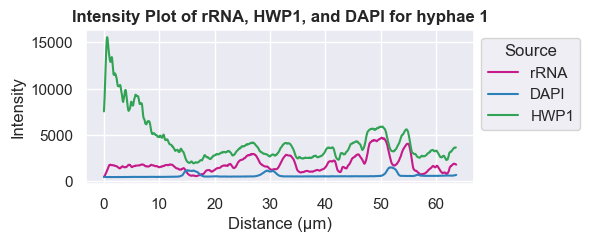

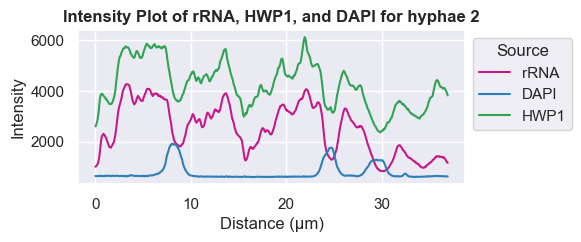

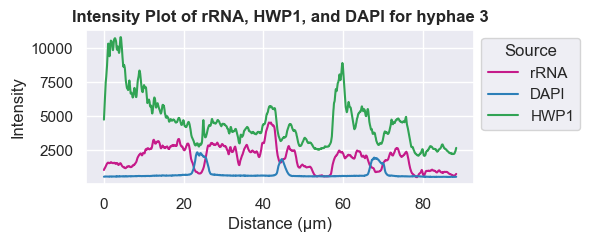

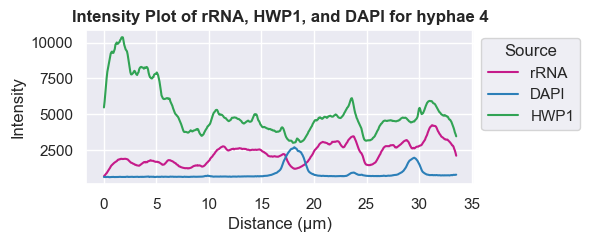

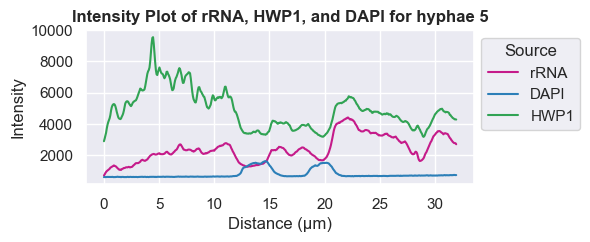

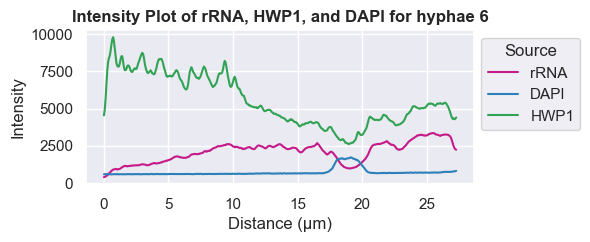

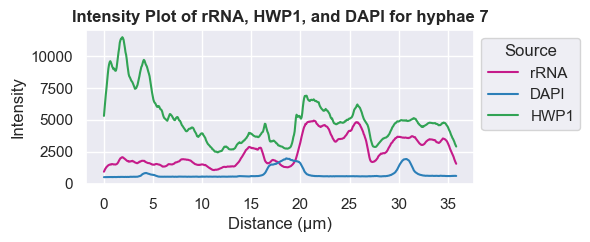

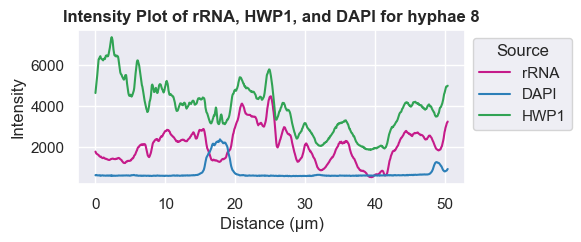

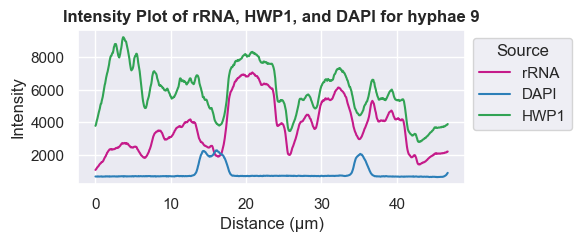

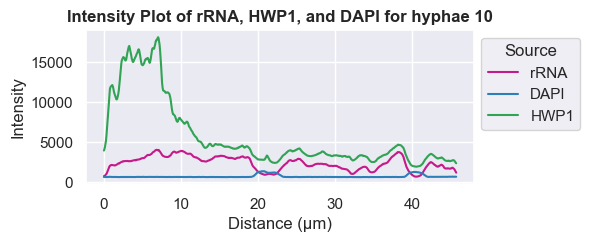

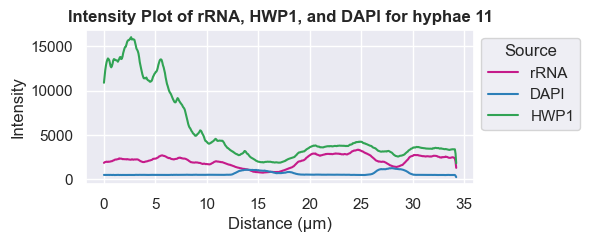

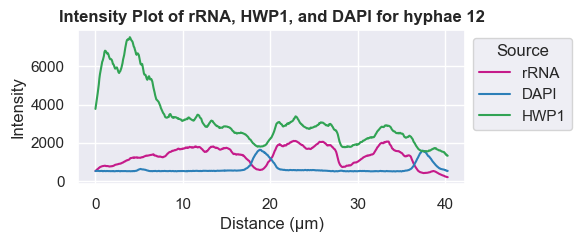

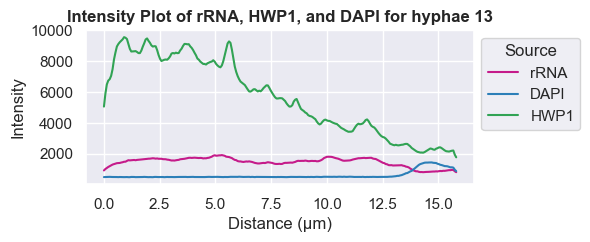

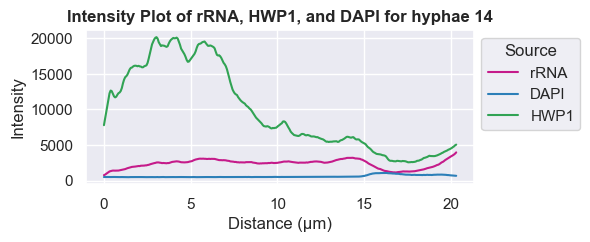

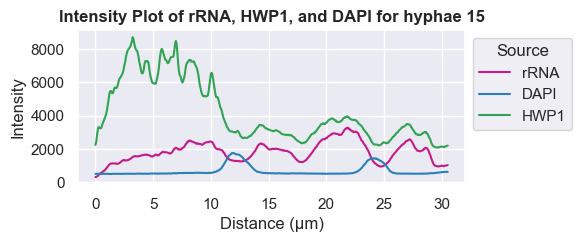

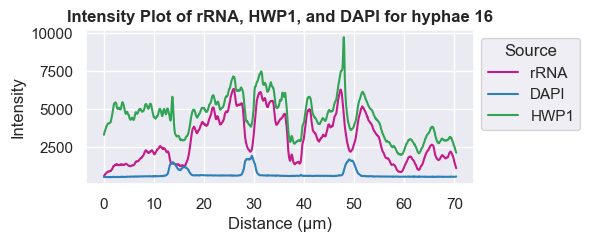

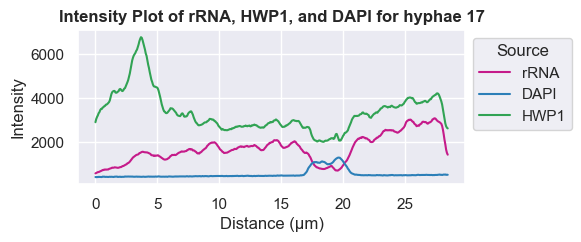

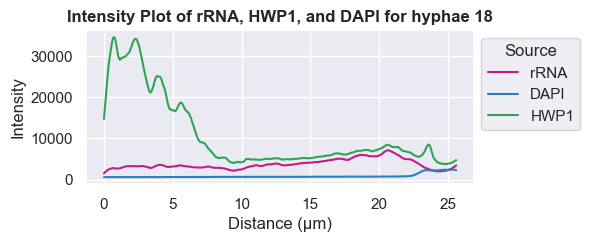

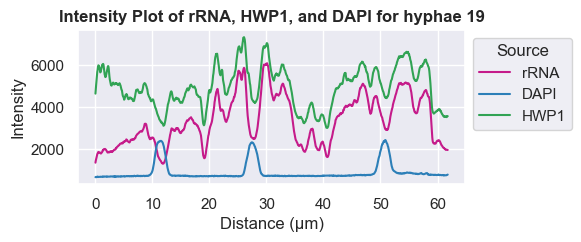

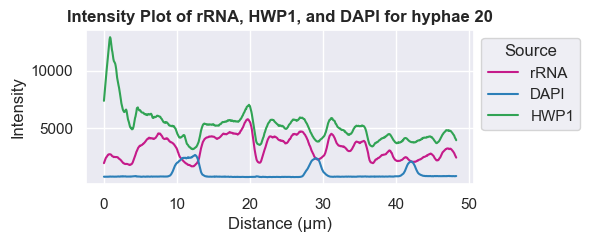

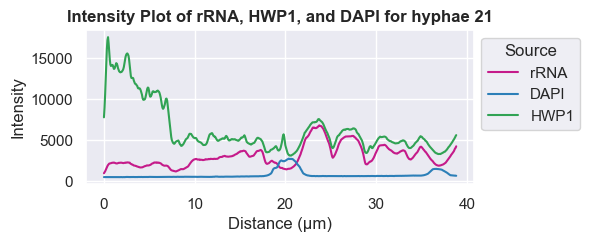

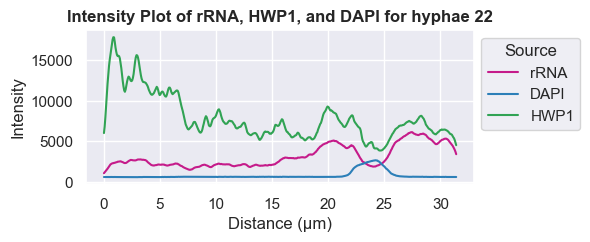

In [5]:
# Set the style for the plot (optional)
sns.set(style="darkgrid")
# Group the data by 'Source' (hyphae number)
groups = result_df.groupby('Source')

# Specify the colors for each column
palette = {'rRNA': '#c51b8a', 'DAPI': '#2c7fb8', 'HWP1': '#31a354'}
iteration = 0
# Plot the lines
for i, group in groups:
    iteration = iteration + 1
    plt.figure(figsize=(5, 2))
    for column in ['rRNA', 'DAPI', 'HWP1']:
        sns.lineplot(x='distance_um', y=column, data=group, label=f'{column}', color=palette[column])    
    # Set plot labels and title
    plt.xlabel('Distance (μm)')
    plt.ylabel('Intensity')
    plt.title(f'Intensity Plot of rRNA, HWP1, and DAPI for hyphae {iteration}', fontsize = 12, fontweight = 'bold')
    plt.legend(title='Source', loc='upper left', bbox_to_anchor=(1, 1))

    # Show the plot
    plt.savefig(f'../data/6hr/plots/hyphae{iteration}_intesityplot.png', dpi=1000, bbox_inches='tight')
    plt.show()

## Plotting of mean intensity for all hyphae tips of a specific timestamp

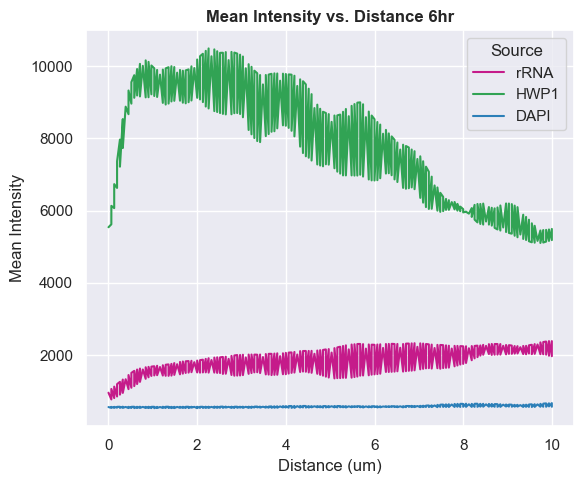

In [6]:
# Filter the data for the first 10 um
df_first_10um = result_df[result_df['distance_um'] <= 10]

# Calculate the mean intensity for each type (rRNA, HWP1, DAPI)
mean_intensity = df_first_10um.groupby('distance_um')[['rRNA', 'HWP1', 'DAPI']].mean().reset_index()

# Plot using Seaborn
sns.set(style="darkgrid")
plt.figure(figsize=(6, 5))

# Plot the mean intensity lines
sns.lineplot(x='distance_um', y='rRNA', data=mean_intensity, color='#c51b8a', label='rRNA')
sns.lineplot(x='distance_um', y='HWP1', data=mean_intensity, color='#31a354', label='HWP1')
sns.lineplot(x='distance_um', y='DAPI', data=mean_intensity, color='#2c7fb8', label='DAPI')

# Set plot labels and title
plt.xlabel('Distance (um)')
plt.ylabel('Mean Intensity')
plt.title('Mean Intensity vs. Distance 6hr', fontsize = 12, fontweight = 'bold')

# Show the legend and plot
plt.legend(title='Source', bbox_to_anchor=(0.765, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f'../data/24hr/plots/hyphae_Mean_intesityplot.png', dpi=1000, bbox_inches='tight')

plt.show()

## Plotting mean intensity of all hyphae tips for multiple timestamps

In [7]:
parent_folder_path = '../data/'

#Adjusting dataframe to encompass all timestamps

subfolders = ['6hr', '24hr']  # Add more subfolders as needed

desired_columns = ['Distance_(inches)', 'rRNA', 'DAPI', 'HWP1']
result_df = pd.DataFrame()
dfs = []

for subfolder in subfolders:
    folder_path = os.path.join(parent_folder_path, subfolder)
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path, usecols=desired_columns)
            df['Source'] = filename
            df['Subfolder'] = subfolder
            dfs.append(df)

result_df = pd.concat(dfs, ignore_index=True)
# result_df.to_csv('../data/combined_data.csv', index=False)

result_df['distance_um'] = result_df['Distance_(inches)'] * 6.192

print(result_df)

       Distance_(inches)     rRNA       HWP1      DAPI  \
0                0.00000  518.964   7562.467   490.390   
1                0.01040  548.292   8336.876   494.711   
2                0.02080  606.155   9208.737   495.968   
3                0.03120  665.785  10409.733   488.436   
4                0.04170  774.331  11680.508   494.798   
...                  ...      ...        ...       ...   
19527            3.58333  429.144   3007.767  5479.314   
19528            3.59375  429.533   2993.901  5374.501   
19529            3.60417  419.831   3006.465  5344.320   
19530            3.61458  416.832   2971.989  5249.263   
19531            3.62500  372.542   2580.046  4669.806   

                         Source Subfolder  distance_um  
0         Rep2_PlotValues_1.csv       6hr     0.000000  
1         Rep2_PlotValues_1.csv       6hr     0.064397  
2         Rep2_PlotValues_1.csv       6hr     0.128794  
3         Rep2_PlotValues_1.csv       6hr     0.193190  
4         Rep2_Plo

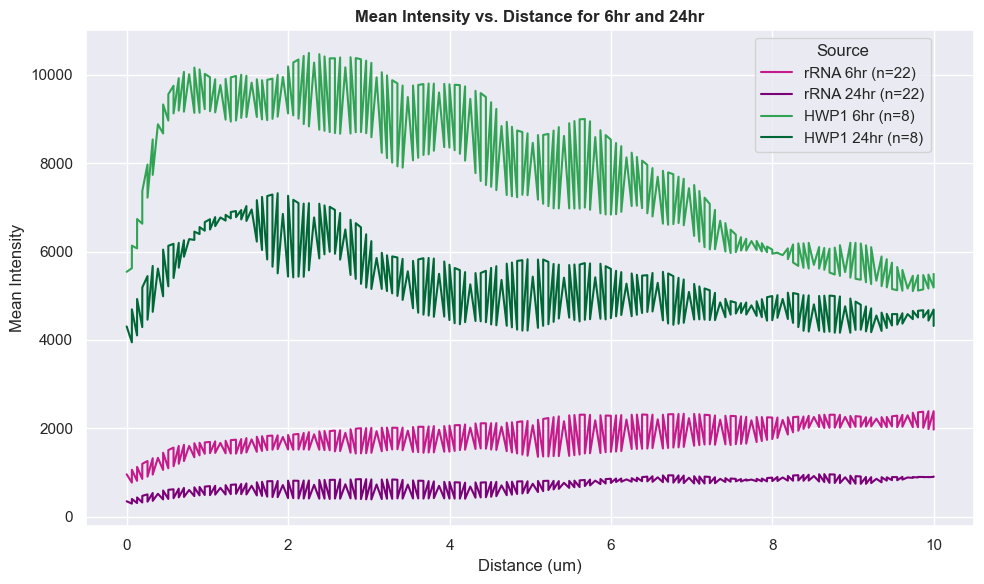

In [39]:
#Selecting only the first 10 um of the tip
df_first_10um = result_df[result_df['distance_um'] <= 10]

cell_counts = {}
mean_intensity = df_first_10um.groupby(['distance_um', 'Subfolder'])[['rRNA', 'HWP1']].mean().reset_index()

sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))

#Adding cell counts for later use in legend
numbers = [22,22,8,8]
i = 0

#Making sure the colours are correct
for typ in ['rRNA', 'HWP1']:
    i = i + 1
    for subfolder in ['6hr', '24hr']:
        color_key = f"{typ}_{subfolder}"
        if typ == "rRNA":
            if subfolder == "6hr":
                colors = "#c51b8a"
            else:
                colors = "#7a0177"
        if typ == "HWP1":
            if subfolder == "6hr":
                colors = "#31a354"
            else:
                colors = "#006837"
                
        data = mean_intensity[(mean_intensity['Subfolder'] == subfolder)]
        sns.lineplot(x='distance_um', y=typ, data=data, color=colors, label=f'{typ} {subfolder} (n={numbers[i]})', legend=False)

#plotting labels & legend
plt.xlabel('Distance (um)')
plt.ylabel('Mean Intensity')
plt.title('Mean Intensity vs. Distance for 6hr and 24hr', fontsize = 12, fontweight = 'bold')
plt.legend(title='Source', bbox_to_anchor=(0.745, 1), loc='upper left')

plt.savefig(f'../data/24hr/plots/6hr24hrhyphae_Mean_intesityplot.png', dpi=1000, bbox_inches='tight')


plt.tight_layout()
plt.show()

## Plotting mean intensity of all hyphae tips for multiple timestamps, distance is binned

C:\Users\roana\AppData\Local\Temp\ipykernel_22968\3841123839.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_first_10um['distance_bin'] = pd.cut(df_first_10um['distance_um'], bins=bins[1], labels=bin_labels)


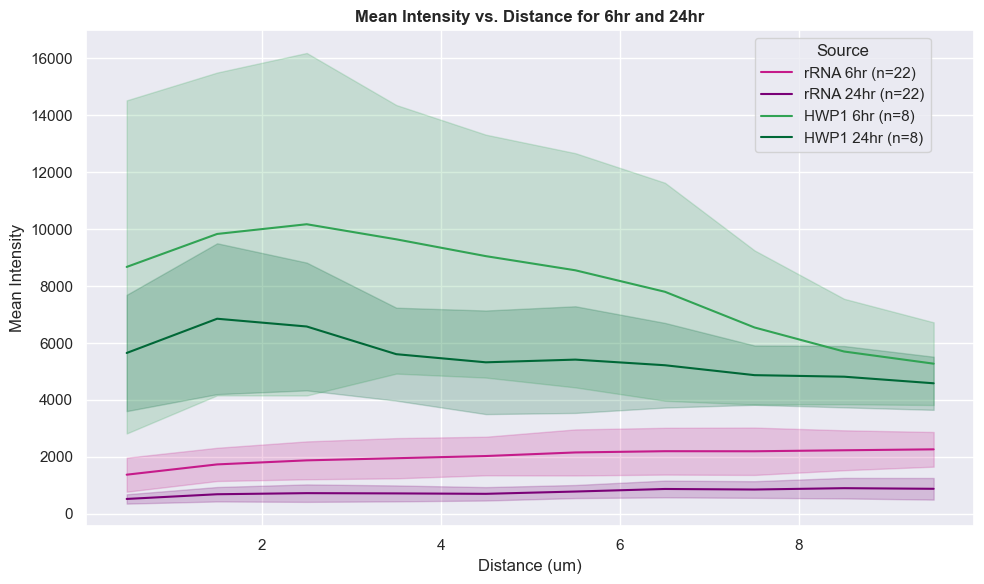

In [8]:
# Selecting first 10 um at tip
df_first_10um = result_df[result_df['distance_um'] <= 10]

# Binning the distance values
bins = pd.cut(df_first_10um['distance_um'], bins=10, retbins=True)  # Define the number of bins here
bin_labels = bins[1][:-1] + (bins[1][1] - bins[1][0]) / 2  # Midpoints of the bins
df_first_10um['distance_bin'] = pd.cut(df_first_10um['distance_um'], bins=bins[1], labels=bin_labels)

# Group by 'distance_bin' and 'Subfolder' columns and calculate the mean intensity and standard deviation
grouped_data = df_first_10um.groupby(['distance_bin', 'Subfolder'])[['rRNA', 'HWP1']]
mean_intensity = grouped_data.mean().reset_index()
std_intensity = grouped_data.std().reset_index()

sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))

numbers = [22, 22, 8, 8]
i = 0

for typ in ['rRNA', 'HWP1']:
    i += 1
    for subfolder in ['6hr', '24hr']:
        color_key = f"{typ}_{subfolder}"
        if typ == "rRNA":
            if subfolder == "6hr":
                colors = "#c51b8a"
            else:
                colors = "#7a0177"
        if typ == "HWP1":
            if subfolder == "6hr":
                colors = "#31a354"
            else:
                colors = "#006837"
                
        mean_data = mean_intensity[(mean_intensity['Subfolder'] == subfolder)]
        std_data = std_intensity[(std_intensity['Subfolder'] == subfolder)]
        
        # Plot mean intensity line
        sns.lineplot(x='distance_bin', y=typ, data=mean_data, color=colors, label=f'{typ} {subfolder} (n={numbers[i]})', legend=False)
        
        # Plot standard deviation lines
        plt.fill_between(mean_data['distance_bin'], mean_data[typ] - std_data[typ], mean_data[typ] + std_data[typ], color=colors, alpha=0.2)

plt.xlabel('Distance (um)')
plt.ylabel('Mean Intensity')
plt.title('Mean Intensity vs. Distance for 6hr and 24hr', fontsize=12, fontweight='bold')

plt.legend(title='Source', bbox_to_anchor=(0.745, 1), loc='upper left')

plt.savefig(f'../data/24hr/plots/6hr24hrhyphae_Mean_intesityplot.png', dpi=1000, bbox_inches='tight')

plt.tight_layout()
plt.show()

### Plotting individual hyphae within same plot

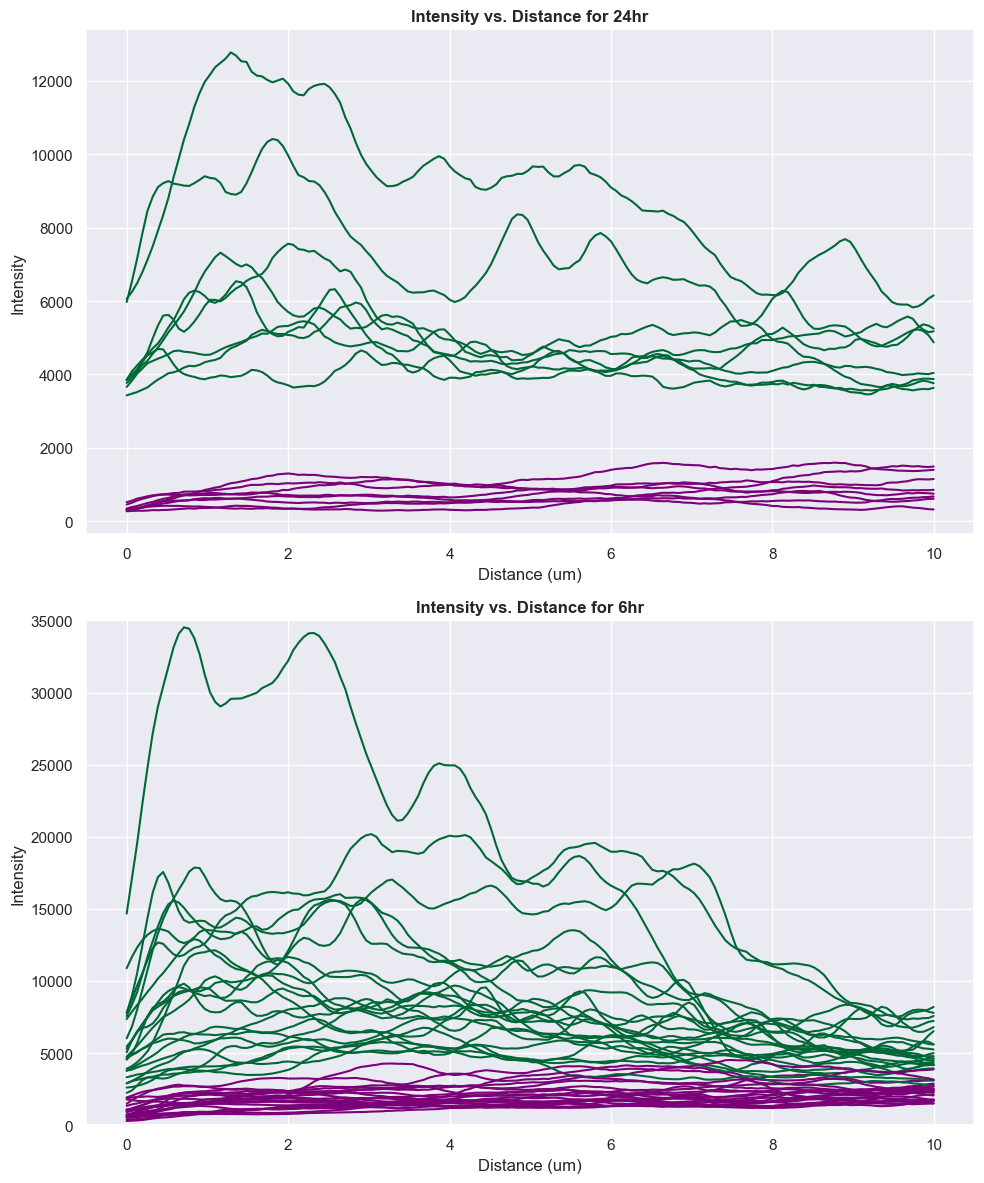

In [10]:
# Selecting first 10 um at tip
df_first_10um = result_df[result_df['distance_um'] <= 10]  # Filter the data for the first 10 um

# Set custom colors for each subfolder
colors_dict = {
    '6hr': {'rRNA': "#7a0177", 'HWP1': "#006837"},
    '24hr': {'rRNA': "#7a0177", 'HWP1': "#006837"}
}

# Plot using Seaborn
sns.set(style="darkgrid")

# Create separate figures and axes for 6hr and 24hr plots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

# Group by 'Subfolder' column
grouped = df_first_10um.groupby('Subfolder')

# Loop over each subfolder
for i, (subfolder, data) in enumerate(grouped):
    # Initialize plot for the current subfolder
    ax = axes[i]
    
    # Group data by 'Source'
    source_grouped = data.groupby('Source')
    
    # Loop over each source
    for source, source_data in source_grouped:
        # Get the colors for rRNA and HWP1 for the current subfolder
        color_rRNA = colors_dict[subfolder]['rRNA']
        color_HWP1 = colors_dict[subfolder]['HWP1']
        
        # Plot the individual data points for rRNA
        sns.lineplot(x='distance_um', y='rRNA', data=source_data, color=color_rRNA, label=f'rRNA {source}', linestyle='-', ax=ax, legend = False)

        # Plot the individual data points for HWP1
        sns.lineplot(x='distance_um', y='HWP1', data=source_data, color=color_HWP1, label=f'HWP1 {source}', linestyle='-', ax=ax, legend = False)
        plt.ylim(0,35000)

    # Set plot labels and title for the current subfolder
    ax.set_xlabel('Distance (um)')
    ax.set_ylabel('Intensity')
    ax.set_title(f'Intensity vs. Distance for {subfolder}', fontsize=12, fontweight='bold')

plt.savefig(f'../data/24hr/plots/6hr24hrhyphae_divided_intesityplot.png', dpi=1000, bbox_inches='tight')

# Adjust layout and show plots
plt.tight_layout()
plt.show()